In [ ]:
!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata --quiet
!pip3 install torch torchaudio torchvision torchtext torchdata --quiet
!pip3 install torchdiffeq torchdyn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.8 MB/s eta 0:00:00


In [ ]:
import os
import shutil

# Create folders to store the training results
- mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- create folders to store the training results.

In [ ]:
p2colab = '/content/drive/MyDrive/Colab Notebooks'
utils = "utils"

os.path.isdir(os.path.join(p2colab, utils)) or os.mkdir(os.path.join(p2colab, utils))
os.path.isdir("./utils") or shutil.copytree(os.path.join(p2colab, utils), './utils')

os.path.isdir(os.path.join(p2colab, "OT-Flow")) or os.mkdir(os.path.join(p2colab, "OT-Flow"))
os.path.isfile("./Phi.py") or shutil.copy2(os.path.join(p2colab, "Phi.py"), "./")

p2gaussians = os.path.join(p2colab, "OT-Flow", "gaussians")
os.path.isdir(p2gaussians) or os.mkdir(p2gaussians)

p2moons = os.path.join(p2colab, "OT-Flow", "moons")
os.path.isdir(p2moons) or os.mkdir(p2moons)

p2spheres = os.path.join(p2colab, "OT-Flow", "spheres")
os.path.isdir(p2spheres) or os.mkdir(p2spheres)

True

# Import packages
- import `Phi` object from `Phi`
- import `utils` folders' `CheckPoint` and `ToyModels`
  - `CheckPoint`: a module used to store checkpoint into `.pth` file.
  - `ToyModels`: a module consists of three functions, used to generate the toy model datasets.

In [ ]:
from Phi import *
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint
from utils.ToyModels import *
from utils.CheckPoint import *
import matplotlib.pyplot as plt
import progressbar
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

# Define Objects
- `OdeFunc`: The ODE equation group we want to learn.
- `compute_loss`: the function used to calculate the loss.

In [ ]:
class OdeFunc(nn.Module):
    """
        Generate the object of ODE function we want to learn.
    :param d: int: dimension of the input
    :param m: int: dimension of the hidden layer
    :param nTh: int: number of the thetas
    """
    def __init__(self, d: int, m:int, nTh: int):
        super(OdeFunc, self).__init__()
        self.d = d
        self.m = m
        self.nTh = nTh
        self.net = Phi(self.nTh, self.m, self.d).to(device)

    """
        Forward pass of the ODE function
    :param t: torch.Tensor: time
    :param x: torch.Tensor: input in dimension d + 3, the augment vector [z, l, L, R] (where z is the d dimension random variable.)
    :return: torch.Tensor: output of the ODE function
    """
    def forward(self, t, x):
        x = x[:, :self.d]
        z = torch.cat((x, t*torch.ones(x.shape[0],1).to(device)), 1)
        gradPhi, trH = self.net.trHess(z)
        dx = - gradPhi[:,:self.d]
        dl = - trH.unsqueeze(1)
        dv = 0.5 * torch.sum(torch.pow(dx, 2), 1, keepdim=True)
        dr = torch.abs(-gradPhi[:,-1].unsqueeze(1) +  dv)
        return torch.cat((dx, dl, dv, dr), 1)

# Define the loss function according to the eq. (6) in our report
def compute_loss(x: torch.Tensor, alpha=torch.tensor([1.0,1.0,1.0])):
    d = x.shape[1] - 3
    C = 1/2 * torch.sum(torch.pow(x[:, :d], 2), dim=1) - x[:, -3] + torch.log(torch.tensor([2]) * torch.pi).to(device)
    L = torch.mean(x[:,-2])
    R = torch.mean(x[:,-1])
    return torch.mean(C) * alpha[0] + L * alpha[1] + R * alpha[2]

- Create a dataframe used to store the iterations and the loss.

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=["itr", "loss"])

In [ ]:
d = 2
m = 64
OTFlow = OdeFunc(d,m, 2).to(device)     # Initialize the ODE function
optimizer = optim.Adam(OTFlow.parameters(), lr=1e-3)
t0 = 0
t1 = 1

## Gaussians distribution

In [ ]:
# Define the function to generate batches for model training
def get_batch(n_sample):
    x, _ = generate_gaussians_data(n_samples=n_sample)
    return x

In [ ]:
checkpoint = torch.load(os.path.join(p2gaussians, "gaussians11800.pth"))
checkpoint['epoch']
OTFlow.load_state_dict(checkpoint['model_state_dict'])
OTFlow.eval()
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

NameError: name 'p2gaussians' is not defined

In [ ]:
# Training the model
for itr in progressbar.progressbar(range(checkpoint['epoch']+1, checkpoint['epoch'] + 200+1)):
  optimizer.zero_grad()
  x = get_batch(12000).to(device)
  x = F.pad(x,[0,3,0,0],  value=0).to(device)
  t = torch.tensor([t0,t1], dtype=torch.float32).to(device)
  _,x0 = odeint(OTFlow, x, t,
              method='dopri5',
              atol=1e-5,
              rtol=1e-5)
  loss = compute_loss(x0)
  loss.backward()
  optimizer.step()
  df.loc[len(df)] = [itr, loss.item()]
  # print(x0)

  if itr % 200 == 0:
    df.to_csv(os.path.join(p2gaussians, "gaussians{}.csv".format(itr)))
    df = pd.DataFrame(columns=["itr", "loss"])
    save_checkpoint(OTFlow, itr, optimizer, loss, os.path.join(p2gaussians, "gaussians{}.pth".format(itr)))




100% (200 of 200) |######################| Elapsed Time: 0:00:46 Time:  0:00:46


## Moons distribution

In [ ]:
d = 2
m = 64
OTFlow = OdeFunc(d,m, 2).to(device)
optimizer = optim.Adam(OTFlow.parameters(), lr=1e-3)
t0 = 0
t1 = 1
df = pd.DataFrame(columns=["itr", "loss"])
def get_batch(n_sample):
  x, _ = generate_moon_data(n_samples=n_sample, noise=2e-1)
  return x

In [ ]:
checkpoint = torch.load(os.path.join(p2moons, "moons64200.pth"))
checkpoint['epoch']
OTFlow.load_state_dict(checkpoint['model_state_dict'])
OTFlow.eval()
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
for itr in progressbar.progressbar(range(checkpoint['epoch'] + 1, checkpoint['epoch'] + 20000+1)):
  optimizer.zero_grad()
  x = get_batch(20000).to(device)
  x = F.pad(x,[0,3,0,0],  value=0).to(device)
  t = torch.tensor([t0,t1], dtype=torch.float32).to(device)
  _,x0 = odeint(OTFlow, x, t,
              method='dopri5',
              atol=1e-5,
              rtol=1e-5)
  loss = compute_loss(x0)
  loss.backward()
  optimizer.step()
  df.loc[len(df)] = [itr, loss.item()]
  # print(x0)

  if itr % 200 == 0:
    df.to_csv(os.path.join(p2moons, "moons{}.csv".format(itr)))
    df = pd.DataFrame(columns=["itr", "loss"])
    save_checkpoint(OTFlow, itr, optimizer, loss, os.path.join(p2moons, "moons{}.pth".format(itr)))



NameError: name 'checkpoint' is not defined

# Spheres

In [ ]:
d = 2
m = 64
OTFlow = OdeFunc(d,m, 2).to(device)
optimizer = optim.Adam(OTFlow.parameters(), lr=1e-3)
t0 = 0
t1 = 1
df = pd.DataFrame(columns=["itr", "loss"])
def get_batch(n_sample):
  x, _ = generate_spheres_data(n_sample, noise=8e-2)
  return x

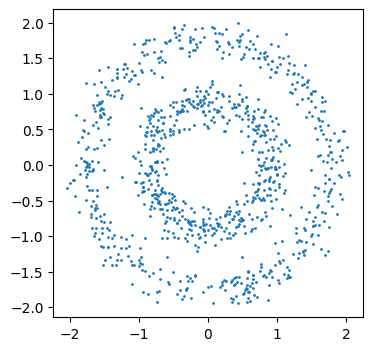

In [ ]:
fig = plt.figure(figsize=(4,4))
plt.scatter(*get_batch(1000).T, s =1)

In [ ]:
checkpoint = torch.load(os.path.join(p2spheres, "spheres3200.pth"))
checkpoint['epoch']
OTFlow.load_state_dict(checkpoint['model_state_dict'])
OTFlow.eval()
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

NameError: name 'torch' is not defined

In [ ]:
for itr in progressbar.progressbar(range(1, 20000+1)):
  optimizer.zero_grad()
  x = get_batch(20000).to(device)
  x = F.pad(x,[0,3,0,0],  value=0).to(device)
  t = torch.tensor([t0,t1], dtype=torch.float32).to(device)
  _,x0 = odeint(OTFlow, x, t,
              method='dopri5',
              atol=1e-5,
              rtol=1e-5)
  loss = compute_loss(x0, alpha=torch.tensor([2,1,1]))
  loss.backward()
  optimizer.step()
  df.loc[len(df)] = [itr, loss.item()]
  # print(x0)

  if itr % 100 == 0:
    df.to_csv(os.path.join(p2spheres, "spheres{}.csv".format(itr)))
    df = pd.DataFrame(columns=["itr", "loss"])
    save_checkpoint(OTFlow, itr, optimizer, loss, os.path.join(p2spheres, "spheres{}.pth".format(itr)))


 74% (14817 of 20000) |#############     | Elapsed Time: 5:00:07 ETA:   1:42:18